Mount Drive

In [1]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


setting project workspace

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S9')

In [3]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/EVA4/S9/*

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/datasetloader.py'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/README.md'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/S9_Assignment.ipynb'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/train_test.py'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/utils.py'

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/gradcam':
gradcam.py  __init__.py  __pycache__  utils.py

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/models':
__pycache__  resnet.py	s7_model.py

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/__pycache__':
datasetloader.cpython-36.pyc  train_test.cpython-36.pyc  utils.cpython-36.pyc

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/transform':
albu_transforms.py  __init__.py  __pycache__  pytorch_transforms.py


Import Libraries

In [4]:
!pip install albumentations==0.4.5

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
#import torchvision.transforms as transforms
from torchsummary import summary
from tqdm import tqdm
import torch.backends.cudnn as cudnn

from transform.albu_transforms import *
import datasetloader as d
from models.resnet import *
from train_test import train, test


Loading data

In [0]:
# This is already available in albu_transforms.py
from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize, Cutout, Rotate, GaussianBlur, VerticalFlip
from albumentations.pytorch import ToTensor, ToTensorV2
import numpy as np


# Albumentations Transformations
transform_train_albu = Compose([
    RandomCrop(height=32, width=32), #, always_apply=True 
    HorizontalFlip(p=0.2),
    VerticalFlip(p=0.0),
    GaussianBlur(p=0.0),
    Rotate(limit=20),
    #ToTensor(),
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010), always_apply=True),
    Cutout(num_holes=1, max_h_size=16, max_w_size=16, fill_value=[0.4914, 0.4822, 0.4465], p=0.3),
    ToTensorV2(always_apply=True)
])


transform_test_albu = Compose([
    #ToTensor(),
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ToTensorV2(always_apply=True)
])

transform_test_albu = AlbuCompose(transform_test_albu)
transform_train_albu = AlbuCompose(transform_train_albu)

In [7]:
# setting up random seed and processing device
SEED = 1
cuda = torch.cuda.is_available()
if cuda:
    device = "cuda"
    torch.cuda.manual_seed(SEED)
else:
    device = "cpu"
    torch.manual_seed(SEED)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## getting training data loader
trainloader = d.get_dataloader_CIFAR10(True, cuda, transform=transform_train_albu)

## getting test data loader
testloader = d.get_dataloader_CIFAR10(False, cuda, transform=transform_test_albu)


Files already downloaded and verified
Files already downloaded and verified


initializing network architecture

In [8]:
!pip install torchsummary
from torchsummary import summary
net = ResNet18()
net = net.to(device)
if cuda:
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Model training and Evaluation

In [9]:
# loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

# Model Training and Evaluation
for epoch in range(0, 25):
    train(net, device, trainloader, optimizer, epoch, criterion)
    test(net, device, testloader, criterion)


epoch=0 Loss=1.3587716817855835 Batch_id=390 Accuracy=39.67: 100%|██████████| 391/391 [00:22<00:00, 17.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0110, Accuracy: 4941/10000 (49.4%)



epoch=1 Loss=0.9154666066169739 Batch_id=390 Accuracy=53.99: 100%|██████████| 391/391 [00:21<00:00, 17.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 5873/10000 (58.7%)



epoch=2 Loss=0.999140739440918 Batch_id=390 Accuracy=60.66: 100%|██████████| 391/391 [00:21<00:00, 17.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 6335/10000 (63.4%)



epoch=3 Loss=0.9295713305473328 Batch_id=390 Accuracy=65.94: 100%|██████████| 391/391 [00:21<00:00, 17.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 6806/10000 (68.1%)



epoch=4 Loss=0.6980608701705933 Batch_id=390 Accuracy=69.51: 100%|██████████| 391/391 [00:21<00:00, 17.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 6990/10000 (69.9%)



epoch=5 Loss=0.8066484332084656 Batch_id=390 Accuracy=72.47: 100%|██████████| 391/391 [00:21<00:00, 17.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7446/10000 (74.5%)



epoch=6 Loss=0.646809458732605 Batch_id=390 Accuracy=74.61: 100%|██████████| 391/391 [00:21<00:00, 17.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7613/10000 (76.1%)



epoch=7 Loss=0.7032300233840942 Batch_id=390 Accuracy=76.72: 100%|██████████| 391/391 [00:21<00:00, 17.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 7275/10000 (72.8%)



epoch=8 Loss=0.7560616135597229 Batch_id=390 Accuracy=78.39: 100%|██████████| 391/391 [00:21<00:00, 17.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 7590/10000 (75.9%)



epoch=9 Loss=0.5662831664085388 Batch_id=390 Accuracy=80.10: 100%|██████████| 391/391 [00:21<00:00, 17.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7909/10000 (79.1%)



epoch=10 Loss=0.5746180415153503 Batch_id=390 Accuracy=81.30: 100%|██████████| 391/391 [00:21<00:00, 17.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7820/10000 (78.2%)



epoch=11 Loss=0.5125037431716919 Batch_id=390 Accuracy=82.22: 100%|██████████| 391/391 [00:21<00:00, 17.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7828/10000 (78.3%)



epoch=12 Loss=0.34241387248039246 Batch_id=390 Accuracy=83.23: 100%|██████████| 391/391 [00:21<00:00, 17.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7986/10000 (79.9%)



epoch=13 Loss=0.5324293375015259 Batch_id=390 Accuracy=84.21: 100%|██████████| 391/391 [00:21<00:00, 17.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8098/10000 (81.0%)



epoch=14 Loss=0.34118416905403137 Batch_id=390 Accuracy=85.20: 100%|██████████| 391/391 [00:21<00:00, 17.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8105/10000 (81.0%)



epoch=15 Loss=0.2793932855129242 Batch_id=390 Accuracy=85.95: 100%|██████████| 391/391 [00:22<00:00, 17.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 8022/10000 (80.2%)



epoch=16 Loss=0.39755183458328247 Batch_id=390 Accuracy=86.64: 100%|██████████| 391/391 [00:21<00:00, 17.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8240/10000 (82.4%)



epoch=17 Loss=0.32157376408576965 Batch_id=390 Accuracy=87.47: 100%|██████████| 391/391 [00:21<00:00, 17.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8256/10000 (82.6%)



epoch=18 Loss=0.5408658981323242 Batch_id=390 Accuracy=87.65: 100%|██████████| 391/391 [00:21<00:00, 17.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8182/10000 (81.8%)



epoch=19 Loss=0.40395084023475647 Batch_id=390 Accuracy=88.33: 100%|██████████| 391/391 [00:21<00:00, 18.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8178/10000 (81.8%)



epoch=20 Loss=0.4043563902378082 Batch_id=390 Accuracy=88.79: 100%|██████████| 391/391 [00:21<00:00, 17.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8160/10000 (81.6%)



epoch=21 Loss=0.1813073456287384 Batch_id=390 Accuracy=89.51: 100%|██████████| 391/391 [00:21<00:00, 17.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8142/10000 (81.4%)



epoch=22 Loss=0.3318863809108734 Batch_id=390 Accuracy=89.51: 100%|██████████| 391/391 [00:21<00:00, 17.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8313/10000 (83.1%)



epoch=23 Loss=0.3152998089790344 Batch_id=390 Accuracy=89.99: 100%|██████████| 391/391 [00:21<00:00, 17.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 8192/10000 (81.9%)



epoch=24 Loss=0.3893251419067383 Batch_id=390 Accuracy=90.37: 100%|██████████| 391/391 [00:21<00:00, 17.99it/s]



Test set: Average loss: 0.0040, Accuracy: 8404/10000 (84.0%)



## Test the GridCAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck  deer  ship  frog


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


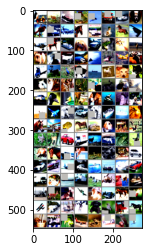

In [10]:
# Let's visualize some of the images
from utils import *
from gradcam.utils import visualize_cam
from gradcam.gradcam import GradCAM
from torchvision.utils import make_grid, save_image
import torch
import torchvision.transforms.functional as F
from torchvision import datasets, transforms


# get some random training images
dataiter = iter(trainloader)
images_orig, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images_orig))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# get one image to test
image_test = images_orig[3]
pil_img = F.to_pil_image(image_test)

#normed_torch_img = transform_test_albu(pil_img).to(device)

# call the transformation. To keep it simple, we are calling PyTorch way of transform
torch_img = transforms.Compose([
    transforms.ToTensor()
])(pil_img).to(device)
normed_torch_img = transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))(torch_img)[None]

# Call the GridCAM
config = dict(model_type='resnet', arch=net, layer_name='layer4')
gradcam = GradCAM.from_config(**config)

images = []

mask, _ = gradcam(normed_torch_img)
heatmap, result = visualize_cam(mask, torch_img)

images.extend([torch_img.cpu(), heatmap, result])
    
grid_image = make_grid(images, nrow=5)

**Show the actual image and GridCAM**

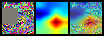

In [11]:
transforms.ToPILImage()(grid_image)